In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent over iterations

In [2]:
from numpy import genfromtxt
from math import exp

my_data = genfromtxt('titanic.csv', delimiter=',', skip_header=1)
a = my_data[:,1]
b = np.zeros((a.shape[0], 3))
b[np.arange(a.shape[0]), a.astype(int)-1] = 1
#print(b)
my_data = np.delete(my_data, (1), axis = 1)
my_data = np.insert(my_data, 1, b[:,0], axis = 1)
my_data = np.insert(my_data, 2, b[:,1], axis = 1)
my_data = np.insert(my_data, 3, b[:,2], axis = 1)
#print('My Data', my_data)

X_train = my_data[:800,1:].T
print('X_train', X_train, X_train.shape)
Y_train = my_data[:800,0]
Y_train = np.append(Y_train, 1-Y_train).reshape((2, -1))
print('Y_train', Y_train, Y_train.shape)

X_test = my_data[800:,1:].T
print('X_test', X_test, X_test.shape)
Y_test = my_data[800:,0]
Y_test = np.append(Y_test, 1-Y_test).reshape((2, -1))
print('Y_test', Y_test, Y_test.shape)

X_train [[ 0.      1.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 1.      0.      1.     ...  1.      1.      1.    ]
 ...
 [ 1.      1.      0.     ...  0.      0.      1.    ]
 [ 0.      0.      0.     ...  0.      0.      1.    ]
 [ 7.25   71.2833  7.925  ...  8.6833  7.2292 24.15  ]] (8, 800)
Y_train [[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]] (2, 800)
X_test [[  0.       0.       1.       0.       0.       0.       1.       0.
    0.       1.       0.       0.       0.       0.       0.       1.
    0.       0.       0.       0.       1.       0.       1.       0.
    0.       0.       0.       0.       0.       1.       0.       0.
    0.       0.       0.       1.       0.       0.       0.       1.
    0.       0.       1.       0.       0.       0.       0.       0.
    0.       1.       0.       0.       0.       1.       0.       0.
    1.       1.       0.       0.       0.       0.       1.       0.
    0.      

### 4.1 - Defining the neural network structure ####
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer
    - n_y: the size of the output layer

In [3]:
# initialize_parameters

def initialize_parameters(layer):
    """
    Argument:
    layer -- array size of the each layer
            starts with input and end with output
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    parameters = {}
    for index in range(1, len(layer)):
        prev_layer = layer[index-1]
        curr_layer = layer[index]
        parameters['W' + str(index)] = np.random.randn(curr_layer, prev_layer) * 0.01
        parameters['b' + str(index)] = np.zeros(shape=(curr_layer, 1))
        parameters['lrW' + str(index)] = np.zeros((curr_layer, prev_layer))
        parameters['lrb' + str(index)] = np.zeros((curr_layer, 1))
    parameters['depth'] = len(layer)
        
    return parameters

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
#forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    cache = {}
    A_before = X
    for index in range(1, parameters['depth']-1):
        weight = parameters['W' + str(index)]
        bias = parameters['b' + str(index)]
        Z_cache = np.dot(weight, A_before) + bias
        A_cache = np.tanh(Z_cache)
        cache['Z' + str(index)] = Z_cache
        cache['A' + str(index)] = A_cache
        A_before = A_cache
        
    weight = parameters['W' + str(parameters['depth']-1)]
    bias = parameters['b' + str(parameters['depth']-1)]
    Z_cache = np.dot(weight, A_before) + bias
    A_cache = sigmoid(Z_cache)
    cache['Z' + str(parameters['depth']-1)] = Z_cache
    cache['A' + str(parameters['depth']-1)] = A_cache
    
    return A_cache, cache

In [6]:
# Gcompute_cost

def compute_cost(A_last, Y, parameters):
    """
    
    Arguments:
    A_last -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A_last), Y) + np.multiply((1 - Y), np.log(1 - A_last))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    
    return cost

In [7]:
# backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # Backward propagation: calculate dW1, db1, dW2, db2.
    grads = {}
    curr_index = parameters['depth']-1
    dZ_curr = cache['A' + str(curr_index)] - Y
    dZ_before = dZ_curr
    A_before = cache['A' + str(curr_index-1)]
    grads['dW' + str(curr_index)] = (1/m) * np.dot(dZ_curr, A_before.T)
    grads['db' + str(curr_index)] = (1/m) * np.sum(dZ_curr, axis=1, keepdims=True)
    for index in reversed(range(1, parameters['depth']-1)):
        A_curr = cache['A' + str(index)]
        dZ_curr = np.multiply(np.dot(parameters['W' + str(index + 1)].T, dZ_before), 1 - np.power(A_curr, 2))
        dZ_before = dZ_curr
        A_before = cache['A' + str(index-1)] if index > 1 else X
        grads['dW' + str(index)] = (1/m) * np.dot(dZ_curr, A_before.T)
        grads['db' + str(index)] = (1/m) * np.sum(dZ_curr, axis = 1, keepdims=True)
    
    return grads

In [8]:
# update_parameters


def update_parameters(parameters, grads, learning_rate = 0.1):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    # Update rule for each parameter
    for index in range(1, parameters['depth']):
        #print(grads['dW' + str(index)])
        parameters['W' + str(index)] = parameters['W' + str(index)] - learning_rate * grads['dW' + str(index)]
        parameters['b' + str(index)] = parameters['b' + str(index)] - learning_rate * grads['db' + str(index)]
    
    return parameters

In [9]:
def next_batch(X_complete, Y_complete, mini_batch):
    """
    Arguments:
    X_complete -- the complete dataset of X
    Y_complete -- the complete dataset of Y
    mini_batch -- integer that represent the mini batch size
    """
    current_batch = 0
    while current_batch * mini_batch < X_complete.shape[1]:
        lower = current_batch * mini_batch
        upper = (current_batch+1) * mini_batch
        current_batch += 1
        yield X_complete[:,lower:upper], Y_complete[:,lower:upper]

###  Combine all the above into a  nn_model() funcction ####

In [10]:
# nn_model

def nn_model(X_train, Y_train, n_h, num_iterations = 10000, learning_rate = 0.1, mini_batch = 32, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = X_train.shape[0] # size of input layer
    n_y = Y_train.shape[0] # size of output layer
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters([n_x, *n_h, n_y])
    
    # Loop (gradient descent)
    train_error = []
    test_error = []
    train_lost = []

    for i in range(0, num_iterations):
        
        for X, Y in next_batch(X_train, Y_train, mini_batch):

            # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
            output, cache = forward_propagation(X, parameters)

            # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
            cost = compute_cost(output, Y, parameters)

            # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
            grads = backward_propagation(parameters, cache, X, Y)

            # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
            parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i %f lr: %f" %(i, learning_rate, cost))
         
        if i % 50 == 0:
            train_lost.append(cost)
        
            predictions = predict(parameters, X_train)
            accuracy = np.sum(predictions.T == Y_train.T) / 2 / Y_train.shape[1]
            train_error.append(1-accuracy)

            predictions = predict(parameters, X_test)
            accuracy = np.sum(predictions.T == Y_test.T) / 2 / Y_test.shape[1]
            test_error.append(1-accuracy)
        
    plt.figure(figsize=(5,5))
    plt.title('Training Lost', fontsize=20)
    plt.xlabel('Number of epochs', fontsize=12)
    plt.ylabel('Average cross entropy', fontsize=12)
    x_loc = list(i for i in range(0, num_iterations, 50))
    y_loc = train_lost
    plt.plot(x_loc, y_loc)
    plt.show()
    
    plt.figure(figsize=(5,5))
    plt.title('Training Error Rate', fontsize=20)
    plt.xlabel('Number of epochs', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    x_loc = list(i for i in range(0, num_iterations, 50))
    y_loc = train_error
    plt.plot(x_loc, y_loc)
    plt.show()
    
    plt.figure(figsize=(5,5))
    plt.title('Test Error', fontsize=20)
    plt.xlabel('Number of epochs', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    x_loc = list(i for i in range(0, num_iterations, 50))
    y_loc = test_error
    plt.plot(x_loc, y_loc)
    plt.show()

    return parameters

In [11]:
# predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    output, cache = forward_propagation(X,parameters)
    #print(str(list(A2)))
    #maxi = np.maximum.reduce(tuple(arr for arr in output))
    row_maxes = output.T.max(axis=1).reshape(-1, 1)
    predictions = np.where(output.T == row_maxes, 1, 0)
    #print(output)
    
    return predictions.T

Cost after iteration 0 0.010000 lr: 1.383389
Cost after iteration 1000 0.010000 lr: 0.720143
Cost after iteration 2000 0.010000 lr: 0.607303
Cost after iteration 3000 0.010000 lr: 0.641744
Cost after iteration 4000 0.010000 lr: 0.615286
Cost after iteration 5000 0.010000 lr: 0.935402


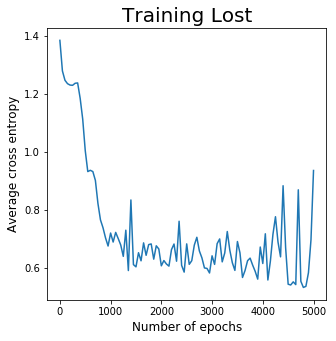

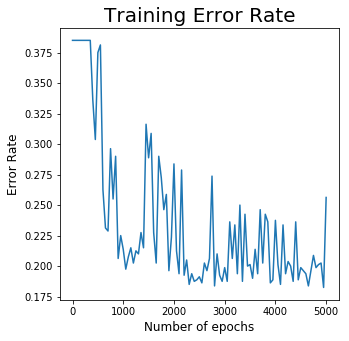

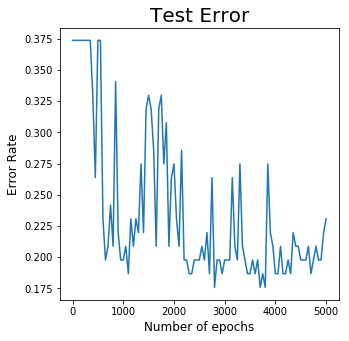

Accuracy for [3, 3] hidden 0.01 lr 128 minibatch: 76.92307692307693 %
-----------------------------------------------------------------------------------


In [14]:
# Running the model with diffrent number of neurons in the hiddern layer
learn_rate = [0.01]
hidden_layer_sizes = [[3,3]]
batch = [128]
for n_h in hidden_layer_sizes:
    for lr in learn_rate:
        for mini_batch in batch:
            parameters = nn_model(X_train, Y_train, n_h, num_iterations = 5001, learning_rate = lr, mini_batch = mini_batch, print_cost=True)
            predictions = predict(parameters, X_test)
            accuracy = np.sum(predictions.T == Y_test.T) / 2 / Y_test.shape[1] * 100
            print ("Accuracy for {} hidden {} lr {} minibatch: {} %".format(n_h, lr, mini_batch, accuracy))
            print('-----------------------------------------------------------------------------------')